<img src='https://hospitalityinsights.ehl.edu/hubfs/AdobeStock_308332890.jpeg' align='left' width='75%'/>

**Authors:** Nate Currit <br>
**Copyright:** 2022 Nate Currit <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h3>Geographic Object-Based Image Analysis (GEOBIA)</h3></div>

# INTRODUCTION

### Learning outcomes

At the end of this notebook you will know;
* The steps of GEOBIA image classification
* How to perform GEOBIA using open source tools


### Outline

Here you could describe your notebook, and perhaps include <a href="https://notebook.wekeo.eu/" target="_blank">links</a> to any relevant external content. 

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Background](#background)
 2. [Segmentation](#segmentation)
 3. [Attribution](#attribution)
 4. [Classification](#classification)
 5. [Challenge](#challenge)


<hr>

<div class="alert alert-info" role="alert">

## <a id='background'></a>1. Background
[Back to top](#TOC_TOP)

</div>

## Pixel-based vs Object-based classifications
Two broad types of image classification exist: pixel-based and object-based. In **pixel-based** classifications, individual pixels are classified indepently of neighboring pixels. 

**Object-based** classifications recognize spatial relationships between neighboring pixels.

## High resolution vs Low resolution imagery
Orbital and sub-orbital imagery has 4 unique kinds of resolution: spatial, spectral, radiometric and temporal. This section focuses on spatial resolution in the context of GEOBIA. 

A few new terms have been proposed and used: H' high resolution imagery and L' low resolution imagery. Here, high and low spatial resolution are defined by their relation to geographic objects of interest on the ground. H' resolution imagery has pixels that are smaller than objects of interest. That is, there are more than 1 H' pixels per object of interest. L' resolution imagery has 1 or fewer pixels per object of interest

## Data for this tutorial
#### Data used (example - you can change this to suit your data sets)

| Product Description | Data Store collection ID| Product Navigator | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 SLSTR level-1B | EO:EUM:DAT:0411 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:SL_1_RBT___NTC?query=SLSTR&s=advanced" target="_blank">link</a> | EO:EUM:DAT:SENTINEL-3:SL_1_RBT___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3ASL_1_RBT___&initial=1" target="_blank">link</a> |### Data used (example - you can change this to suit your data sets)

In [54]:
print(f"Band 1 max: {image[0].max()}")
print(f"Shape of Band 1 is {image[0].shape}")
print(f"Band 2 max: {image[1].max()}")
print(f"Shape of Band 1 is {image[1].shape}")
print(f"Band 3 max: {image[2].max()}")
print(f"Shape of Band 1 is {image[2].shape}")
print(f"Band 4 max: {image[3].max()}")
print(f"Shape of Band 1 is {image[3].shape}")

Band 1 max: 4676.0
Shape of Band 1 is (445, 554)
Band 2 max: 5280.0
Shape of Band 1 is (445, 554)
Band 3 max: 5296.0
Shape of Band 1 is (445, 554)
Band 4 max: 7036.0
Shape of Band 1 is (445, 554)


In [59]:
(image[0]/image[0].max()).shape

(445, 554)

In [55]:
display = np.stack(image[0]/image[0].max(), image[1]/image[1].max(), image[2]/image[2].max())

TypeError: only integer scalar arrays can be converted to a scalar index

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


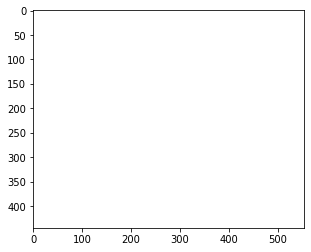

<AxesSubplot:>

In [46]:
image.max()
rasterio.plot.show(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

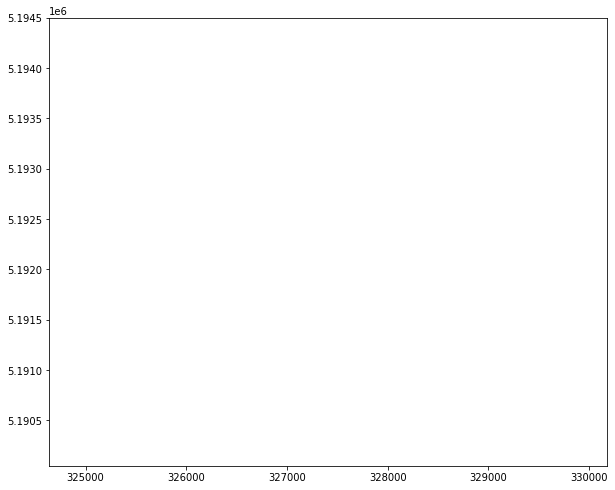

In [42]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(image[:3], ax = ax, transform = src.transform)

Due to the bands we have selected, and the fact that this is a level-1 product, the image above is quite difficult to interpret. However with some understanding of the synoptic scale and typical patterns of different ocean and atmosphere features, we can see that the TIR bands can reveal variability associated with sea and land surfaces, and clouds/the atmosphere. This is the fundamental basis of how we can use this data for a diverse range of applications.

<div class="alert alert-info" role="alert">

## <a id='segmentation'></a>2. Segmentation
[Back to top](#TOC_TOP)

</div>

Segmentation is what primarily distinguishes GEOBIA from pixel-based classification methods. It is the most critical part of the GEOBIA process.

Before running the segmentation code below, we load a few utilities.

In [19]:
# Runs functions found in an accompanying notebook 
%run ./functions.ipynb

#### Select algorithm and set parameters

In [34]:
slic_params = {
    'compactness': 0.00001,
    'n_segments': 3000,
    'slic_zero': True,
    'convert2lab': True,
    'enforce_connectivity': True
}

felz_params = {
    'scale': 0.0001,
    'sigma': 0.7,
    'min_size': 10
}

quickshift_params = {
    'channel_axis': 2,
    'ratio': 0.009,
    'sigma': 1.3,
    'convert2lab': True
}

#### Segment image

In [21]:
src = rasterio.open("data/concise.tif")

image = src.read()

print(f"Starting segmentation.", end="...")

# SLIC
# rout = segmentation(model=slic, params=slic_params, image=image[:3])

# Quickshift
rout = segmentation(model=quickshift, params=quickshift_params, image=image[:3], sieve_size=20)

# Felzenszwalb
# rout = segmentation(model=felzenszwalb, params=felz_params, image=image[:3], sieve_size=30)

print(f"done.")

Starting segmentation....done.


#### Vectorize raster segments

In [22]:
print(f"Starting vectorization.", end="...")
vout = vectorize(image=rout, transform=src.transform,
                crs=src.crs.to_proj4())
print(f"done.")

Starting vectorization....done.


/home/nate/.cache/pypoetry/virtualenvs/notebook-competition-KIuzUzOD-py3.8/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

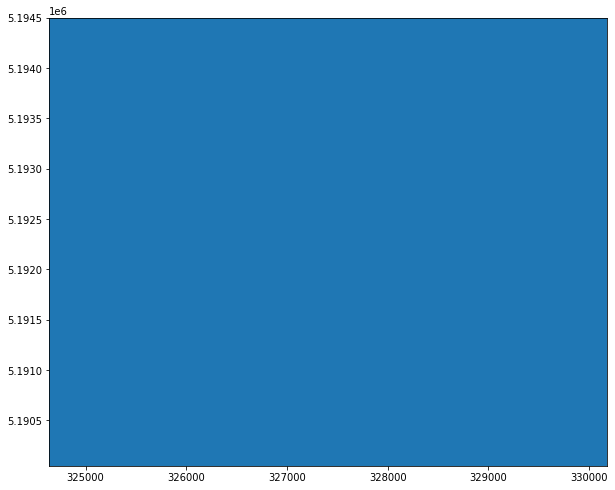

In [43]:
f, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(image[:3], ax = ax, transform = src.transform)
vout.plot(ax = ax)

<div class="alert alert-info" role="alert">

## <a id='attribution'></a>3. Attribution
[Back to top](#TOC_TOP)

</div>

Segment attributes generally fall into 3 categories, spectral, shape and texture.

#### Spectral
Spectral attributes are zonal statistics of the original spectral image bands based on the segments derived above. For example, the average blue, green, red and near infrared pixels values of each segment are recorded as unique fields in the vector segments file. 

#### Shape
Geographic objects in a region may have unique shapes, depending on the resolution characteristics of the imagery. For example, tree crowns may be round, homes may be square, lakes may be elongated, etc. Depending on the objects visible in the imagery and the shape of the segments derived from the previous steps, an analyst can choose from a variety of shape parameters.

#### Texture
A whole range of texture measures

### Spectral attributes

In [25]:
print(f"Starting add zonal spectral properties.", end="...")
vout = add_zonal_properties(image=image, transform=src.transform, 
                            band_names=['blue', 'green', 'red', 'nir'],
                            gdf=vout)
print(f"done.")

Starting add zonal spectral properties....done.


### Shape attributes

In [26]:
print(f"Starting add shape properties.", end="...")
vout = add_shape_properties(rout, vout, ['area', 'perimeter',
                                        'eccentricity', 
                                        'equivalent_diameter',
                                        'major_axis_length',
                                        'minor_axis_length',
                                        'orientation'])
print(f"done.")

Starting add shape properties....done.


### Texture attributes

In [27]:
print(f"Starting edge detection.", end="...")
edges = sobel_edge_detect(image[3])
print(f"done.")

print(f"Starting add zonal texture properties.", end="...")
vout = add_zonal_properties(image=edges, band_names=['edges'],
                            stats=['mean', 'std'],
                            transform=src.transform, gdf=vout)
print(f"done.")

vout.to_file("./segmentation.gpkg", layer="ss1000", driver="GPKG")

Starting edge detection....done.
Starting add zonal texture properties....done.


In [33]:
vout.head()

,geometry,nir_mean,area,perimeter,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,orientation,edges_mean,edges_std,dn
0,"POLYGON ((326370.000 5194500.000, 326370.000 5...",4798.100,2000.0,220.0,0.792700,5.046265,6.777232,4.131480,0.907887,353.961768,178.672359,6
1,"POLYGON ((328440.000 5194500.000, 328440.000 5...",4068.375,2400.0,280.0,0.963649,8.667245,26.553137,7.094198,-1.457752,292.969727,163.057292,2
2,"POLYGON ((328630.000 5194500.000, 328630.000 5...",3885.000,100.0,40.0,0.000000,1.128379,0.000000,0.000000,0.785398,616.840759,0.000000,25
3,"POLYGON ((328640.000 5194500.000, 328640.000 5...",4314.000,300.0,80.0,0.689903,11.617375,15.678748,11.349881,1.194258,533.086833,209.634377,38
4,"POLYGON ((328650.000 5194500.000, 328650.000 5...",4321.000,100.0,40.0,1.000000,1.595769,2.828427,0.000000,-0.785398,195.587906,0.000000,28


<div class="alert alert-info" role="alert">

## <a id='classification'></a>4. Classification
[Back to top](#TOC_TOP)

</div>

## Classification algorithms
Your classification algorithm options are broad.

This tutorial selects RandomForests to classify the segments based on their attributes.

In [7]:
## Classification code here

<div class="alert alert-danger" role="alert">

## <a id='challenge'></a>Challenge.
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-warning">

### Challenge:

A final section of your notebook could invite the user to try and adapt your notebook for their own purposes. This is not necessary but can really help people to learn by applying their new knowled
 <div>

In [9]:
# with rasterio.open("data/concise.tif") as src:
#     slic_params = {
#         'compactness': 0.00001,
#         'n_segments': 3000,
#         'slic_zero': True,
#         'convert2lab': True,
#         'enforce_connectivity': True
#     }

#     felz_params = {
#         'scale': 0.0001,
#         'sigma': 0.7,
#         'min_size': 10
#     }
    
#     # Works pretty good
#     quickshift_params = {
#         'channel_axis': 2,
#         'ratio': 0.009,
#         'sigma': 1.3,
#         'convert2lab': True
#     }

#     image = src.read()

#     print(f"Starting segmentation.", end="...")
    
#     # SLIC
#     # rout = segmentation(model=slic, params=slic_params, image=image[:3])
    
#     # Quickshift
#     rout = segmentation(model=quickshift, params=quickshift_params, image=image[:3], sieve_size=20)
    
#     # Felzenszwalb
#     # rout = segmentation(model=felzenszwalb, params=felz_params, image=image[:3], sieve_size=30)
    
#     print(f"done.")
    
#     print(f"Starting vectorization.", end="...")
#     vout = vectorize(image=rout, transform=src.transform,
#                     crs=src.crs.to_proj4())
#     print(f"done.")
    
#     print(f"Starting add zonal spectral properties.", end="...")
#     vout = add_zonal_properties(image=image, transform=src.transform, 
#                                 band_names=['blue', 'green', 'red', 'nir'],
#                                 gdf=vout)
#     print(f"done.")
    
#     print(f"Starting add shape properties.", end="...")
#     vout = add_shape_properties(rout, vout, ['area', 'perimeter',
#                                             'eccentricity', 
#                                             'equivalent_diameter',
#                                             'major_axis_length',
#                                             'minor_axis_length',
#                                             'orientation'])
#     print(f"done.")
    
#     print(f"Starting edge detection.", end="...")
#     edges = sobel_edge_detect(image[3])
#     print(f"done.")
    
#     print(f"Starting add zonal texture properties.", end="...")
#     vout = add_zonal_properties(image=edges, band_names=['edges'],
#                                 stats=['mean', 'std'],
#                                 transform=src.transform, gdf=vout)
#     print(f"done.")
    
#     vout.to_file("./segmentation.gpkg", layer="ss1000", driver="GPKG")
    
#     print("\nAll done!!")

Starting segmentation....done.
Starting vectorization....done.
Starting add zonal spectral properties....

/home/nate/.cache/pypoetry/virtualenvs/notebook-competition-KIuzUzOD-py3.8/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


done.
Starting add shape properties....done.
Starting edge detection....done.
Starting add zonal texture properties....done.

All done!!
